## Brevitas: Modelo cuantizado

### Modelo 1.0

In [12]:
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFloat, Int8ActPerTensorFloat

# Variables globales para cambiar la entrada de la imagen
W_H_pixels = 64
rgb_l = "L"


# Modelo tipo tinycnn cuantizado, se requirio cambiar CONV2D y MaxPooling a Linear, ya que finn no soportaba ese tipo de capas
class QuantTinyCNN_FINN(nn.Module):
    def __init__(self):
        super(QuantTinyCNN_FINN, self).__init__()
        quantinfo4 = {"weight_quant": Int8WeightPerTensorFloat, "weight_bit_width": 4} 
        quantinfo = {"weight_quant": Int8WeightPerTensorFloat, "weight_bit_width": 8}

        self.fc1 = qnn.QuantLinear(
            in_features=1 * W_H_pixels * W_H_pixels,  # 
            out_features=128,
            bias=True,
            **quantinfo4  # Uso de 4 bits para los pesos en la primera capa, ya que es la más pesada 
        )
        self.relu1 = qnn.QuantReLU(bit_width=4)

        self.fc2 = qnn.QuantLinear(
            in_features=128,
            out_features=64,
            bias=True,
            **quantinfo
        )
        self.relu2 = qnn.QuantReLU(bit_width=4)

        self.fc3 = qnn.QuantLinear(
            in_features=64,
            out_features=32,
            bias=True,
            **quantinfo
        )
        self.relu3 = qnn.QuantReLU(bit_width=4)

        self.fc4 = qnn.QuantLinear(
            in_features=32,
            out_features=2,  # salida para 2 clases
            bias=True,
            **quantinfo
        )

    def forward(self, x):
        # Aplanar entrada (ya no hay conv)
        x = x.reshape(x.size(0), -1)
# 
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)

        return x

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


# Función de cuantización
def quantize_tensor(x, num_bits=8):
    qmin = 0.0
    qmax = 2.0**num_bits - 1.0
    min_val, max_val = x.min(), x.max()
    scale = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    return q_x / qmax  # volver a rango [0,1]


class CustomQuantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        class_mapping = {"bird": 0, "no_bird": 1}

        # Recorre las carpetas "bird" y "no_bird"
        for class_name, label in class_mapping.items():
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for file in os.listdir(class_folder):
                if file.endswith((".png", ".jpg", ".jpeg")):
                    self.image_files.append(os.path.join(class_folder, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("L")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


# Transform cuantizado
from torchvision import transforms


# Aplicar Data Augmentation, rotaciones, flips, cambios de color, normalización
transform_quantized = transforms.Compose(
    [
        transforms.Resize((W_H_pixels, W_H_pixels)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3),
        transforms.RandomResizedCrop(W_H_pixels, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: quantize_tensor(x, num_bits=8)),
        # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        transforms.Normalize([0.5], [0.5]),
    ]
)

val_transform_quantized = transforms.Compose(
    [
        transforms.Resize((W_H_pixels, W_H_pixels)),
        transforms.Lambda(lambda x: quantize_tensor(x, num_bits=8)),
        # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        transforms.Normalize([0.5], [0.5]),

    ]
)

# Crear datasets y loaders
train_dataset = CustomQuantDataset("dataset_split/train", transform=transform_quantized)
val_dataset = CustomQuantDataset("dataset_split/val", transform=val_transform_quantized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Min: -1.0  /// Max: 1.0
dtype: float32


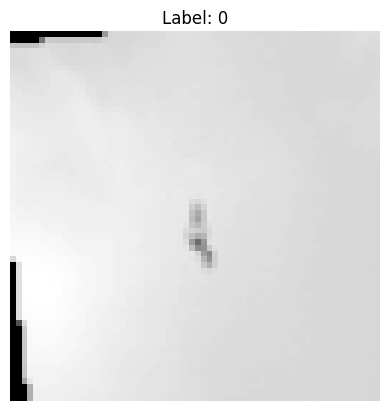

In [14]:
##Color
import matplotlib.pyplot as plt 
import numpy as np 

if rgb_l == "RGB":

    image, label = train_dataset[12] # tu dataset cuantizado 
    image = np.array(image) 
    image = np.transpose(image, (1, 2, 0)) 
    print("Min:", np.min(image), " /// Max:", np.max(image)) 
    print("dtype:", image.dtype) # Plot 
    plt.figure() 
    plt.imshow(image) 
    plt.title(f"Label: {label}")
    plt.show()
else:
    
    image, label = train_dataset[100]  # imagen monocromática
    image = np.array(image)
    
    # Si tiene forma (1, H, W), elimina el canal
    if image.ndim == 3 and image.shape[0] == 1:
        image = image[0]  # ahora es (H, W)
    
    print("Min:", np.min(image), " /// Max:", np.max(image))
    print("dtype:", image.dtype)
    
    # Mostrar como imagen en escala de grises
    plt.figure()
    plt.imshow(image, cmap='gray')  # <- importante para monocromáticas
    plt.title(f"Label: {label}")
    plt.axis('off')

## Entrenamiento con Dataset Custom

In [161]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = QuantTinyCNN_FINN().to(device)
net.train()

# Entrenamiento del dataset, aumentar las epocas puede generar un overfitting

num_epochs = 70
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(num_epochs):
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)  # pérdida promedio por epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%")


cpu
Epoch [1/70], Loss: 0.6116, Accuracy: 67.88%
Epoch [2/70], Loss: 0.5868, Accuracy: 69.12%
Epoch [3/70], Loss: 0.5874, Accuracy: 70.25%
Epoch [4/70], Loss: 0.5715, Accuracy: 72.50%
Epoch [5/70], Loss: 0.5589, Accuracy: 72.00%
Epoch [6/70], Loss: 0.5580, Accuracy: 72.38%
Epoch [7/70], Loss: 0.5463, Accuracy: 73.62%
Epoch [8/70], Loss: 0.5560, Accuracy: 71.62%
Epoch [9/70], Loss: 0.5568, Accuracy: 73.25%
Epoch [10/70], Loss: 0.5313, Accuracy: 73.75%
Epoch [11/70], Loss: 0.5399, Accuracy: 72.25%
Epoch [12/70], Loss: 0.5145, Accuracy: 75.50%
Epoch [13/70], Loss: 0.5268, Accuracy: 73.25%
Epoch [14/70], Loss: 0.5015, Accuracy: 75.38%
Epoch [15/70], Loss: 0.5108, Accuracy: 76.62%
Epoch [16/70], Loss: 0.4999, Accuracy: 75.12%
Epoch [17/70], Loss: 0.4867, Accuracy: 77.50%
Epoch [18/70], Loss: 0.4685, Accuracy: 78.75%
Epoch [19/70], Loss: 0.4745, Accuracy: 77.38%
Epoch [20/70], Loss: 0.4511, Accuracy: 79.00%
Epoch [21/70], Loss: 0.4466, Accuracy: 79.00%
Epoch [22/70], Loss: 0.4607, Accuracy: 

In [125]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

# -----------------------------
# 1. Función de cuantización
# -----------------------------
def quantize_tensor(tensor, num_bits=8):
    qmin = 0.
    qmax = 2.**num_bits - 1.

    min_val, max_val = tensor.min(), tensor.max()
    # Evitar división por cero
    if min_val == max_val:
        return torch.zeros_like(tensor)

    scale = (max_val - min_val) / (qmax - qmin)
    tensor_q = ((tensor - min_val) / scale).round().clamp(qmin, qmax)
    tensor_deq = tensor_q * scale + min_val
    return tensor_deq

# -----------------------------
# 2. Dataset personalizado
# -----------------------------
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        class_mapping = {"bird": 0, "no_bird": 1}
        for class_name, label in class_mapping.items():
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for file in os.listdir(class_folder):
                if file.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_files.append(os.path.join(class_folder, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]   # <- guardar ruta
        image = Image.open(image_path).convert("L")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, image_path       # <- devolver ruta también

# -----------------------------
# 3. Transformaciones
# -----------------------------

# Opción A: sin cuantización
transform_test_no_quant = transforms.Compose([
    transforms.Resize((W_H_pixels, W_H_pixels)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Opción B: con cuantización
transform_test_quant = transforms.Compose([
    transforms.Resize((W_H_pixels, W_H_pixels)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: quantize_tensor(x, num_bits=8)),
    # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    transforms.Normalize(mean=[0.5], std=[0.5])


])

# -----------------------------
# 4. Dataset y DataLoader
# -----------------------------
test_dataset = CustomTestDataset("Images_test", transform=transform_test_quant) 
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# -----------------------------
# 5. Evaluación
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = net.to(device)
net.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels, paths in test_loader:   # <- recibe también paths
        images, labels = images.to(device).float(), labels.to(device)
        out = net(images)
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f"Image: {paths[0]} | Label: {labels.item()} | Pred: {predicted.item()}")

accuracy = 100 * correct / total
print("Accuracy on custom test set:", accuracy, "%")

# Mejora: 
#  - Aumentar los tipos de imagenes en el dataset para poder tener mejor precision en imagenes IR y con gran cantidad de aves 
#  - Más imágenes de prueba 


Image: Images_test/bird/16.jpg | Label: 0 | Pred: 1
Image: Images_test/bird/65a9d7da0d6bb119203b1c13.jpg | Label: 0 | Pred: 1
Image: Images_test/bird/9.jpg | Label: 0 | Pred: 0
Image: Images_test/bird/orig-1437426411440.jpg | Label: 0 | Pred: 1
Image: Images_test/bird/6.jpeg | Label: 0 | Pred: 0
Image: Images_test/bird/13.jpg | Label: 0 | Pred: 0
Image: Images_test/bird/349664072_639634714750284_7488197136792291295_n.jpg | Label: 0 | Pred: 0
Image: Images_test/bird/7.jpeg | Label: 0 | Pred: 1
Image: Images_test/bird/4.jpg | Label: 0 | Pred: 0
Image: Images_test/bird/images_1.jpeg | Label: 0 | Pred: 0
Image: Images_test/bird/pantanos-scaled.jpg | Label: 0 | Pred: 1
Image: Images_test/bird/10.jpeg | Label: 0 | Pred: 0
Image: Images_test/bird/8.jpg | Label: 0 | Pred: 0
Image: Images_test/bird/11.jpg | Label: 0 | Pred: 0
Image: Images_test/no_bird/reducIMG_4616.JPG | Label: 1 | Pred: 1
Image: Images_test/no_bird/dos.jpg | Label: 1 | Pred: 0
Image: Images_test/no_bird/DSC_1491-1024x683.jpg 

In [99]:
print(net.fc1.quant_weight())  # pesos cuantizados
print(net.fc1.quant_weight().int()) 
print(net.fc1.quant_weight().int().dtype) 

QuantTensor(value=tensor([[-0.0094,  0.0094, -0.0094,  ..., -0.0000,  0.0188,  0.0094],
        [ 0.0094,  0.0283,  0.0094,  ...,  0.0188,  0.0188,  0.0188],
        [ 0.0094,  0.0094,  0.0000,  ...,  0.0188, -0.0000, -0.0094],
        ...,
        [ 0.0094,  0.0000,  0.0000,  ...,  0.0283,  0.0094,  0.0188],
        [-0.0000, -0.0188, -0.0188,  ..., -0.0000,  0.0094, -0.0094],
        [-0.0188, -0.0094, -0.0094,  ...,  0.0000,  0.0094,  0.0188]],
       grad_fn=<MulBackward0>), scale=tensor(0.0094, grad_fn=<DivBackward0>), zero_point=tensor(0.), bit_width=tensor(4.), signed_t=tensor(True), training_t=tensor(False))
tensor([[-1,  1, -1,  ...,  0,  2,  1],
        [ 1,  3,  1,  ...,  2,  2,  2],
        [ 1,  1,  0,  ...,  2,  0, -1],
        ...,
        [ 1,  0,  0,  ...,  3,  1,  2],
        [ 0, -2, -2,  ...,  0,  1, -1],
        [-2, -1, -1,  ...,  0,  1,  2]], dtype=torch.int8)
torch.int8


In [100]:
import os
import torch
import numpy as np
from PIL import Image
import brevitas.nn as qnn
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN


user_name = "parasyte"
root_dir = f"/tmp/finn_dev_{user_name}"
     

# -------------------------
# Configuración
# -------------------------
dataset_path = "Images_test"  
image_size = (W_H_pixels, W_H_pixels) 
num_bits = 8  

# -------------------------
# Función de cuantización asimétrica
# -------------------------
def asymmetric_quantize(arr, num_bits=8):
    min_val = 0
    max_val = 2**num_bits - 1

    beta = np.min(arr)
    alpha = np.max(arr)
    scale = (alpha - beta) / max_val
    zero_point = np.clip((-beta / scale), 0, max_val).round().astype(np.int8)

    quantized_arr = np.clip(
        np.round(arr / scale + zero_point), min_val, max_val
    ).astype(np.float32)
    return quantized_arr

# -------------------------
# Cargar una imagen y preprocesar
# -------------------------
def load_and_quantize_image(file_path):
    img = Image.open(file_path).convert("L")
    img = img.resize(image_size)
    img_arr = np.array(img).astype(np.float32) / 255.0 
    # img_arr = img_arr.transpose(2, 0, 1)
    img_arr = np.expand_dims(img_arr, axis=0)  # ahora tiene forma (1, H, W)

    img_q = asymmetric_quantize(img_arr, num_bits=num_bits)
    return img_q

# -------------------------
# Obtener lista solo de imágenes
# -------------------------
def get_image_files_recursive(folder):
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")
    image_files = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(valid_extensions):
                image_files.append(os.path.join(root, f))
    return image_files

image_files = get_image_files_recursive(dataset_path)
if not image_files:
    raise RuntimeError("No se encontraron imágenes en la carpeta.")


# -------------------------
# Crear tensor de entrada usando la primera imagen
# -------------------------
example_image = load_and_quantize_image(image_files[0])
input_t = torch.from_numpy(example_image).unsqueeze(0)  

# -------------------------
# Exportar modelo Brevitas a QONNX
# -------------------------
filename_onnx = os.path.join(root_dir, "part1.onnx")
filename_clean = os.path.join(root_dir, "part1_clean.onnx")

export_qonnx(net, export_path=filename_onnx, input_t=input_t)

# -------------------------
# Limpiar ONNX para FINN
# -------------------------
qonnx_cleanup(filename_onnx, out_file=filename_clean)

# -------------------------
# Convertir a FINN
# -------------------------
model_finn = ModelWrapper(filename_clean)
model_finn = model_finn.transform(ConvertQONNXtoFINN())
model_finn.save(os.path.join(root_dir, "ready_finn.onnx"))

print("Modelo exportado a FINN en: " + os.path.join(root_dir, "ready_finn.onnx"))


Modelo exportado a FINN en: /tmp/finn_dev_parasyte/ready_finn.onnx


/home/parasyte/finn/deps/qonnx/src/qonnx/transformation/gemm_to_matmul.py:57: UserWarning: The GemmToMatMul transformation only offers explicit support for version 9 of the Gemm node, but the ONNX version of the supplied model is 14. Thus the transformation may fail or return incomplete results.
  warnings.warn(
